<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [8]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-05-21 22:43:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2021-05-21 22:43:23 (13.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [9]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [10]:
df.shape

(346, 10)

### Convert to date time object 

In [11]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [12]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

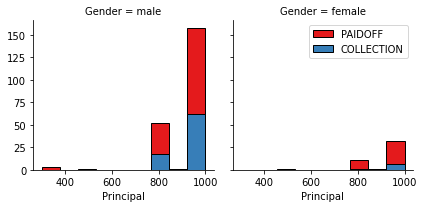

In [13]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

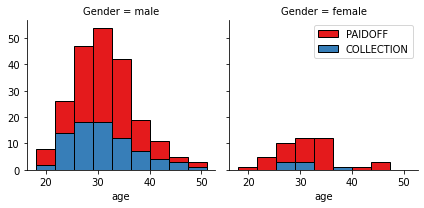

In [14]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

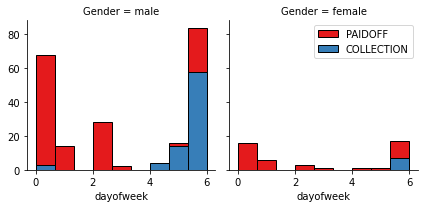

In [15]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [16]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [17]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [18]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [19]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [21]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [23]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

### Train Test Split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Finding best KNN Classification using sklearn

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
accuracy = {}

# Get accruacy for different K
for i in range(1,15):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    accuracy[i] = metrics.accuracy_score(y_test, yhat)

accuracy

{1: 0.735632183908046,
 2: 0.7126436781609196,
 3: 0.7586206896551724,
 4: 0.735632183908046,
 5: 0.7931034482758621,
 6: 0.7816091954022989,
 7: 0.7931034482758621,
 8: 0.7816091954022989,
 9: 0.7701149425287356,
 10: 0.7126436781609196,
 11: 0.7816091954022989,
 12: 0.735632183908046,
 13: 0.7241379310344828,
 14: 0.7471264367816092}

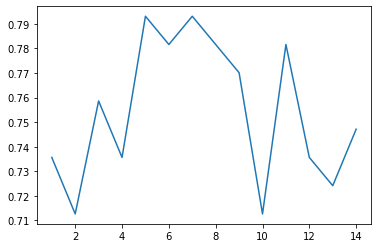

In [27]:
import matplotlib.pyplot as plt
# Plot Accuracy Versus K
plot_x = list(accuracy.keys())
plot_y = list(accuracy.values())

plt.plot(plot_x, plot_y)
plt.show()

In [28]:
# Choosing best k for the highest accuracy
max_k = max(accuracy, key=accuracy.get)
max_k

5

### Final KNN model with high accuracy

In [29]:
knn_model = KNeighborsClassifier(n_neighbors = max_k).fit(X_train, y_train)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test,  knn_model.predict(X_test)))

Train set Accuracy:  0.806949806949807
Test set Accuracy:  0.7931034482758621


# Decision Tree

### Finding best Decision Tree Classification using sklearn

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
accuracy = {}

# Get accruacy for different n
for i in range(1,15):
    dTree = DecisionTreeClassifier(criterion="entropy", max_depth=i).fit(X_train, y_train)
    yhat = dTree.predict(X_test)
    accuracy[i] = metrics.accuracy_score(y_test, yhat)

accuracy

{1: 0.735632183908046,
 2: 0.735632183908046,
 3: 0.735632183908046,
 4: 0.735632183908046,
 5: 0.735632183908046,
 6: 0.7471264367816092,
 7: 0.7011494252873564,
 8: 0.7126436781609196,
 9: 0.7471264367816092,
 10: 0.735632183908046,
 11: 0.7126436781609196,
 12: 0.7241379310344828,
 13: 0.7011494252873564,
 14: 0.7126436781609196}

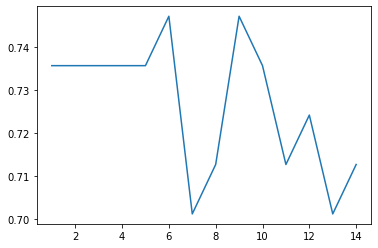

In [31]:
import matplotlib.pyplot as plt
# Plot Accuracy Versus K
plot_x = list(accuracy.keys())
plot_y = list(accuracy.values())

plt.plot(plot_x, plot_y)
plt.show()

In [32]:
# Choosing best n for the highest accuracy
max_n = max(accuracy, key=accuracy.get)
max_n

6

### Final Decision Tree model with high accuracy

In [33]:
dTree_model = DecisionTreeClassifier(criterion="entropy", max_depth=max_n).fit(X_train, y_train)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, dTree_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test,  dTree_model.predict(X_test)))

Train set Accuracy:  0.7722007722007722
Test set Accuracy:  0.7471264367816092


## Visualization

In [ ]:
!pip install graphviz
!pip install pydotplus

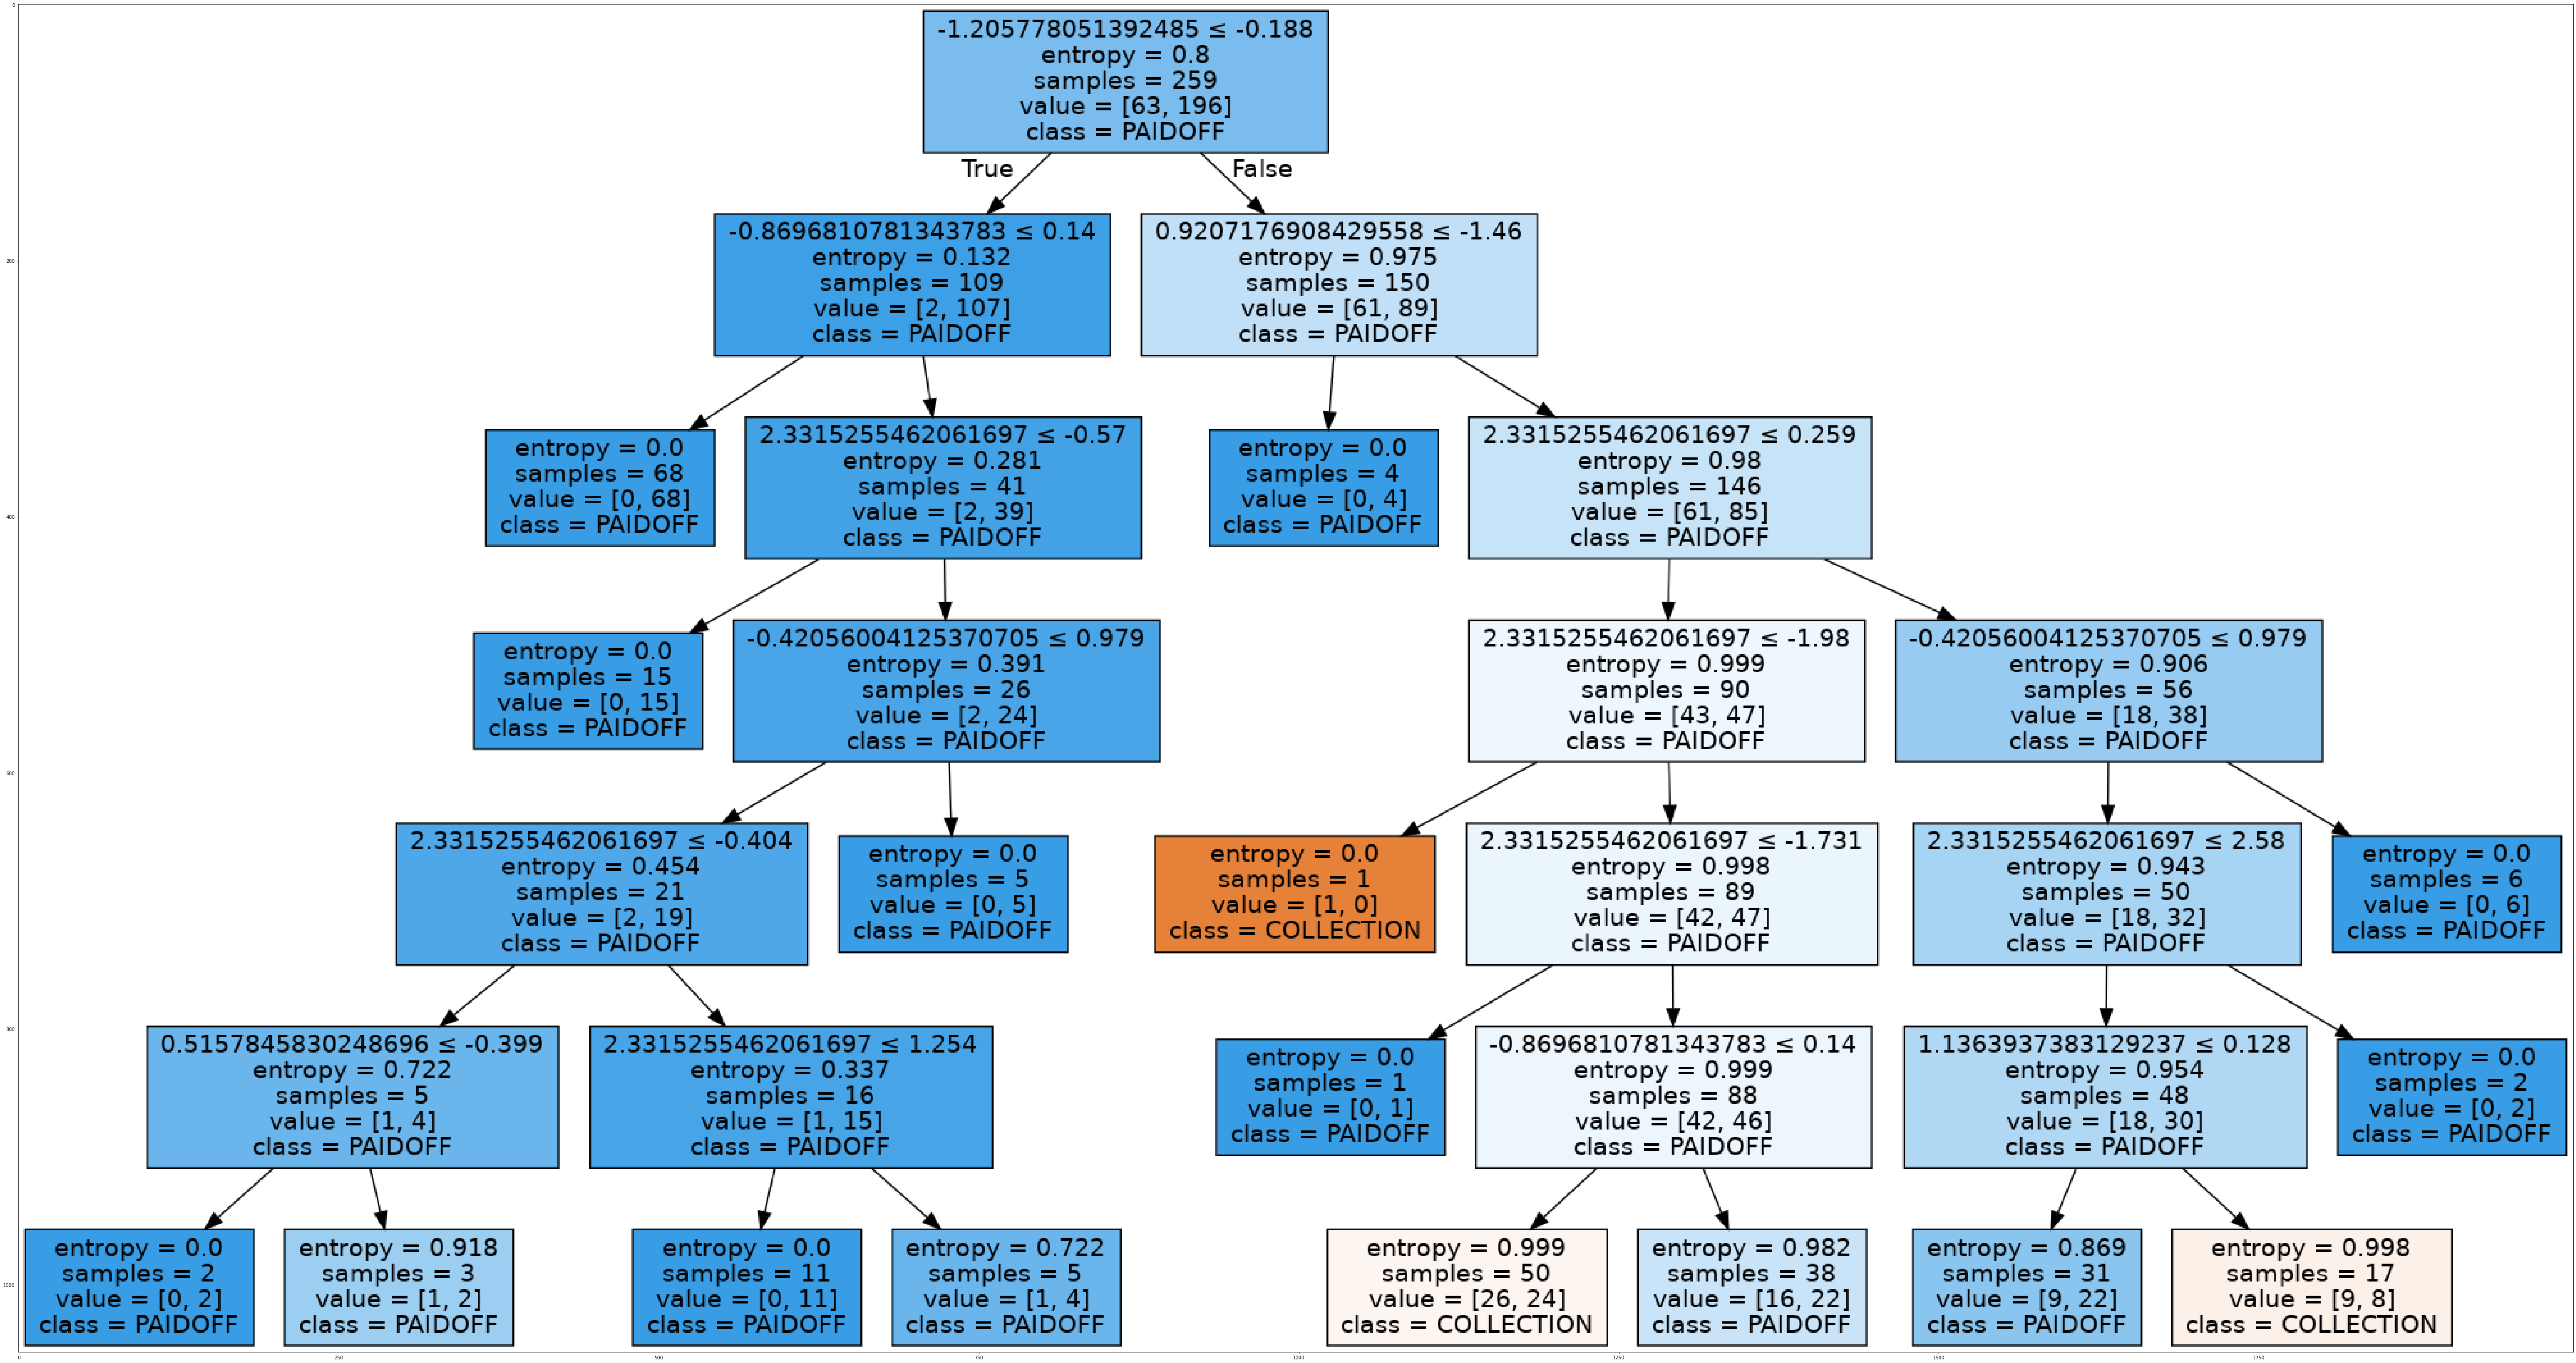

In [36]:
from  io import StringIO
import matplotlib.image as mpimg
import pydotplus
from sklearn import tree
import graphviz
%matplotlib inline 

dot_data = StringIO()
filename = "classification-tree.png"
featureNames = X[0, :]
out=tree.export_graphviz(dTree_model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

### Finding best SVM Classification using sklearn

In [37]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score


kernels = ['linear', 'poly', 'rbf', 'sigmoid'] # different kernels to be used

# dicts to be filled in with the metrics of each kernels
f1_score_dict = {}
jarrord_score_dict = {}
accuracy = {}

for i in range(len(kernels)):
    clf = svm.SVC(kernel=kernels[i]).fit(X_train, y_train)
    yhat = clf.predict(X_test)
    f1_score_dict[kernels[i]] = f1_score(y_test, yhat, average='weighted')
    jarrord_score_dict[kernels[i]] = jaccard_score(y_test,yhat, pos_label="PAIDOFF")
    accuracy[kernels[i]] = metrics.accuracy_score(y_test, yhat)

f1_score_dict, accuracy, jarrord_score_dict

({'linear': 0.6235822486107939,
  'poly': 0.6669534255741152,
  'rbf': 0.6497701149425287,
  'sigmoid': 0.606399502951227},
 {'linear': 0.735632183908046,
  'poly': 0.7471264367816092,
  'rbf': 0.7471264367816092,
  'sigmoid': 0.7011494252873564},
 {'linear': 0.735632183908046,
  'poly': 0.7411764705882353,
  'rbf': 0.7441860465116279,
  'sigmoid': 0.7011494252873564})

### Best SVM Kernel

In [38]:
# Choosing the kernel with the highest accuracy
max_f1_kernel = max(f1_score_dict, key=accuracy.get)
max_jac_kernel = max(jarrord_score_dict, key=accuracy.get)
max_acc_kernel = max(accuracy, key=accuracy.get)

max_f1_kernel, max_jac_kernel, max_acc_kernel

('poly', 'poly', 'poly')

### Final SVM model with the highest accuracy

In [39]:
svm_model = svm.SVC(kernel='poly').fit(X_train, y_train)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test,  svm_model.predict(X_test)))

print("Train set F1-Score: ", metrics.f1_score(y_train, svm_model.predict(X_train), average='weighted'))
print("Test set F1-Score: ", metrics.f1_score(y_test,  svm_model.predict(X_test), average='weighted'))

print("Train set Jaccard Index: ", metrics.jaccard_score(y_train, svm_model.predict(X_train), pos_label="PAIDOFF"))
print("Test set Jaccard Index: ", metrics.jaccard_score(y_test,  svm_model.predict(X_test), pos_label="PAIDOFF"))

Train set Accuracy:  0.7876447876447876
Test set Accuracy:  0.7471264367816092
Train set F1-Score:  0.731874731874732
Test set F1-Score:  0.6669534255741152
Train set Jaccard Index:  0.7782258064516129
Test set Jaccard Index:  0.7411764705882353


# Logistic Regression

### Finding best Logistic Regression Classification using sklearn

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

solver = ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'] # different solvers that could be used

# dicts to be filled in with the metrics of each solvers
f1_score_dict = {}
jarrord_score_dict = {}
log_loss_dict = {}
accuracy = {}

for i in range(len(solver)):
    LR = LogisticRegression(random_state=0, solver=solver[i]).fit(X_train, y_train)
    yhat = LR.predict(X_test)
    yprob = LR.predict_proba(X_test)
    
    f1_score_dict[solver[i]] = f1_score(y_test, yhat, average='weighted')
    jarrord_score_dict[solver[i]] = jaccard_score(y_test, yhat, pos_label="PAIDOFF")
    log_loss_dict[solver[i]] = log_loss(y_test, yprob)
    accuracy[solver[i]] = metrics.accuracy_score(y_test, yhat)

f1_score_dict, jarrord_score_dict, log_loss_dict, accuracy

({'liblinear': 0.6855376733018558,
  'lbfgs': 0.6855376733018558,
  'sag': 0.6855376733018558,
  'saga': 0.6855376733018558,
  'newton-cg': 0.6855376733018558},
 {'liblinear': 0.7228915662650602,
  'lbfgs': 0.7228915662650602,
  'sag': 0.7228915662650602,
  'saga': 0.7228915662650602,
  'newton-cg': 0.7228915662650602},
 {'liblinear': 0.4815184223853896,
  'lbfgs': 0.4823533958362077,
  'sag': 0.48233255772407746,
  'saga': 0.4823016723590858,
  'newton-cg': 0.4823533875624567},
 {'liblinear': 0.735632183908046,
  'lbfgs': 0.735632183908046,
  'sag': 0.735632183908046,
  'saga': 0.735632183908046,
  'newton-cg': 0.735632183908046})

In [41]:
# Choosing the solver with the highest accuracy
max_f1_solver = max(f1_score_dict, key=accuracy.get)
max_jac_solver = max(jarrord_score_dict, key=accuracy.get)
max_log_solver = max(log_loss_dict, key=accuracy.get)
max_acc_solver = max(accuracy, key=accuracy.get)

max_f1_solver, max_jac_solver, max_log_solver, max_acc_solver

('liblinear', 'liblinear', 'liblinear', 'liblinear')

### Final Logistic Regression model with highest accuracy

In [42]:
LR = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, y_train)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test,  LR.predict(X_test)))

print("Train set LogLoss: ", metrics.log_loss(y_train, LR.predict_proba(X_train)))
print("Test set LogLoss: ", metrics.log_loss(y_test,  LR.predict_proba(X_test)))

print("Train set F1-Score: ", metrics.f1_score(y_train, LR.predict(X_train), average='weighted'))
print("Test set F1-Score: ", metrics.f1_score(y_test,  LR.predict(X_test), average='weighted'))

print("Train set Jaccard Index: ", metrics.jaccard_score(y_train, LR.predict(X_train), pos_label="PAIDOFF"))
print("Test set Jaccard Index: ", metrics.jaccard_score(y_test,  LR.predict(X_test), pos_label="PAIDOFF"))

Train set Accuracy:  0.7644787644787645
Test set Accuracy:  0.735632183908046
Train set LogLoss:  0.4216632382046025
Test set LogLoss:  0.4815184223853896
Train set F1-Score:  0.7151109564071758
Test set F1-Score:  0.6855376733018558
Train set Jaccard Index:  0.7540322580645161
Test set Jaccard Index:  0.7228915662650602


# Model Evaluation using Test set

In [43]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [50]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing Test set data

In [52]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [62]:
test_X = test_feature
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [59]:
test_y = test_df['loan_status']
test_y[0:5]

0    PAIDOFF
1    PAIDOFF
2    PAIDOFF
3    PAIDOFF
4    PAIDOFF
Name: loan_status, dtype: object

### Test set accuracy collection with different models

In [67]:
# Dictionary to set the accuracies
test_accuracy = {}

In [69]:
# KNN Model Accuracy
test_accuracy['knn_model_jaccard_score'] = metrics.jaccard_score(test_y,  knn_model.predict(test_X), pos_label='PAIDOFF')
test_accuracy['knn_model_f1_score'] = metrics.f1_score(test_y, knn_model.predict(test_X), average='weighted')

test_accuracy

{'knn_model_jaccard_score': 0.68, 'knn_model_f1_score': 0.6860670194003526}

In [70]:
# Decision Tree Model Accuracy
test_accuracy['decision_tree_model_jaccard_score'] = metrics.jaccard_score(test_y,  dTree_model.predict(test_X), pos_label='PAIDOFF')
test_accuracy['decision_tree_model_f1_score'] = metrics.f1_score(test_y, dTree_model.predict(test_X), average='weighted')

test_accuracy

{'knn_model_jaccard_score': 0.68,
 'knn_model_f1_score': 0.6860670194003526,
 'decision_tree_model_jaccard_score': 0.7555555555555555,
 'decision_tree_model_f1_score': 0.7985191651712822}

In [71]:
# SVM Model Accuracy
test_accuracy['svm_model_jaccard_score'] = metrics.jaccard_score(test_y,  svm_model.predict(test_X), pos_label='PAIDOFF')
test_accuracy['svm_model_f1_score'] = metrics.f1_score(test_y, svm_model.predict(test_X), average='weighted')

test_accuracy

{'knn_model_jaccard_score': 0.68,
 'knn_model_f1_score': 0.6860670194003526,
 'decision_tree_model_jaccard_score': 0.7555555555555555,
 'decision_tree_model_f1_score': 0.7985191651712822,
 'svm_model_jaccard_score': 0.75,
 'svm_model_f1_score': 0.6959228135698723}

In [74]:
# Logistic Model Accuracy
test_accuracy['LR_model_jaccard_score'] = metrics.jaccard_score(test_y,  LR.predict(test_X), pos_label='PAIDOFF')
test_accuracy['LR_model_f1_score'] = metrics.f1_score(test_y, LR.predict(test_X), average='weighted')
test_accuracy['LR_model_log_score'] = metrics.log_loss(test_y, LR.predict_proba(test_X))

test_accuracy

{'knn_model_jaccard_score': 0.68,
 'knn_model_f1_score': 0.6860670194003526,
 'decision_tree_model_jaccard_score': 0.7555555555555555,
 'decision_tree_model_f1_score': 0.7985191651712822,
 'svm_model_jaccard_score': 0.75,
 'svm_model_f1_score': 0.6959228135698723,
 'LR_model_jaccard_score': 0.7547169811320755,
 'LR_model_f1_score': 0.6717642373556352,
 'LR_model_log_score': 0.46901451697197194}

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.68       | 0.686        | NA      |
| Decision Tree      | 0.756       | 0.799        | NA      |
| SVM                | 0.75       | 0.696        | NA      |
| LogisticRegression | 0.755       | 0.672        | 0.47       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>